In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [128]:
# Load the data
df = pd.read_csv('../../data/processed-v2.csv')


In [89]:
# Check for NaN values in the DataFrame
nan_values = df.isnull().sum()
print("NaN values in each column:")
print(nan_values)

NaN values in each column:
product_id                 0
mrp                        0
ram                        0
inbuilt_storage            0
weight                     0
battery_power              0
battery_type               0
form_factor                0
length                     0
width                      0
height                     0
os_name                    0
os_version                 0
phone_warranty (months)    0
camera_count               0
cam_has_AI                 0
cam_has_OIS                0
cam_has_Zoom               0
cam_has_HDR                0
cam_has_Macro              0
cam_has_Portrait           0
main_camera_MP             0
is_success                 0
dtype: int64


In [129]:
# Let's assume 'is_success' is the target variable
y = df['is_success']
X = df.drop(columns=['is_success', 'product_id'], axis=1)
# X = X.replace([np.inf, -np.inf], np.nan)
# df['os_version'].fillna(df['column'].mean(), inplace=True) 

In [130]:
X = X.replace([np.inf, -np.inf], np.nan)
X["os_version"].fillna(X["os_version"].max() * 2, inplace=True)

In [131]:
X["os_version"].describe()

count    646.000000
mean      13.601084
std        9.485235
min        4.400000
25%       11.000000
50%       12.000000
75%       13.000000
max       60.000000
Name: os_version, dtype: float64

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [133]:
# Models list
models_list = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    # ("LightGBM", LGBMClassifier(random_state=42)),
    # ("Support Vector Machines", SVC(random_state=42)),
    # ("XGBoost", XGBClassifier(random_state=42)),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("Bernoulli Naive Bayes", BernoulliNB()),
    ("KNN", KNeighborsClassifier(n_neighbors=3)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Bagging Classifier", BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10))
]

# Initialize DataFrame to store results
result = pd.DataFrame(columns=["Model", "Training Accuracy", "Testing Accuracy", "Classification Report", "Confusion Matrix", "ROC-AUC Score"])

# Loop through models and evaluate performance
for name, model in models_list:
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    train_score = accuracy_score(y_train, train_predictions)
    
    test_predictions = model.predict(X_test)
    test_score = accuracy_score(y_test, test_predictions)

    # Classification Report
    report = classification_report(y_test, test_predictions)

    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, test_predictions)

    # Add results to DataFrame
    new_row = {"Model": name, "Training Accuracy": train_score, "Testing Accuracy": test_score, "Classification Report": report, "Confusion Matrix": cm, "ROC-AUC Score": roc_auc}
    result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)

# Sort the results based on Testing Accuracy
result = result.sort_values(by=["Testing Accuracy", "Training Accuracy"], ascending=False)

# Get the best model (model with the highest testing accuracy)
best_model_name = result.iloc[0]['Model']
best_model = [model for name, model in models_list if name == best_model_name][0]


f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [134]:
print(result)


                   Model  Training Accuracy  Testing Accuracy   
1          Random Forest           1.000000          0.961538  \
5          Decision Tree           1.000000          0.938462   
6     Bagging Classifier           0.996124          0.930769   
4                    KNN           0.947674          0.861538   
0    Logistic Regression           0.736434          0.723077   
2   Gaussian Naive Bayes           0.684109          0.700000   
3  Bernoulli Naive Bayes           0.713178          0.669231   

                               Classification Report      Confusion Matrix   
1                precision    recall  f1-score   ...    [[67, 3], [2, 58]]  \
5                precision    recall  f1-score   ...    [[64, 6], [2, 58]]   
6                precision    recall  f1-score   ...    [[67, 3], [6, 54]]   
4                precision    recall  f1-score   ...   [[57, 13], [5, 55]]   
0                precision    recall  f1-score   ...   [[63, 7], [29, 31]]   
2          

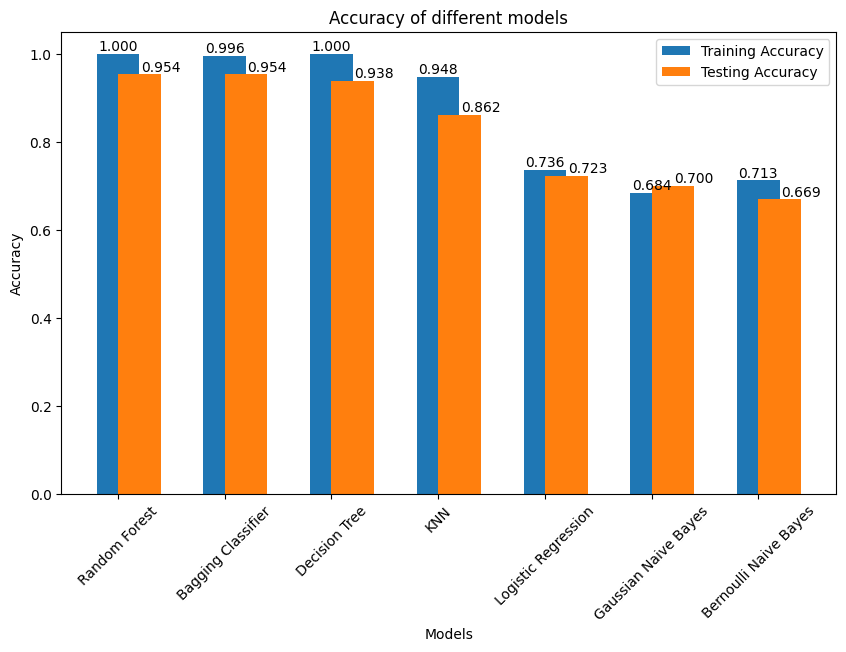

In [100]:
plt.figure(figsize=(10, 6))
bar_width = 0.4
plt.bar(result["Model"], result["Training Accuracy"], width=bar_width, label="Training Accuracy")
plt.bar(result["Model"], result["Testing Accuracy"], width=bar_width, label="Testing Accuracy", align='edge')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of different models')
plt.legend()

# Add labels to the bars
for index, value in enumerate(result["Training Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

for index, value in enumerate(result["Testing Accuracy"]):
    plt.text(index + bar_width, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()


In [101]:
# Feature Importance Analysis
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models like RandomForestClassifier
    feature_importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
else:
    # For linear models like LogisticRegression
    feature_importances = best_model.coef_[0]
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': abs(feature_importances)})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the best model and its feature importance
print("Best Performing Model:", best_model_name)
print("Best Testing Accuracy:", result.iloc[0]['Testing Accuracy'])
print("Classification Report:\n", result.iloc[0]['Classification Report'])
print("Confusion Matrix:\n", result.iloc[0]['Confusion Matrix'])
print("ROC-AUC Score:", result.iloc[0]['ROC-AUC Score'])
print("\nFeature Importance:")
print(feature_importance_df)


Best Performing Model: Random Forest
Best Testing Accuracy: 0.9538461538461539
Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.96      0.96        70
        True       0.95      0.95      0.95        60

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130

Confusion Matrix:
 [[67  3]
 [ 3 57]]
ROC-AUC Score: 0.9535714285714286

Feature Importance:
                    Feature  Importance
3                    weight    0.162096
0                       mrp    0.122042
10                  os_name    0.114523
7                    length    0.077340
11               os_version    0.066253
6               form_factor    0.064367
20           main_camera_MP    0.060132
8                     width    0.058037
4             battery_power    0.049862
9                    height    0.041416
1                       ram    0.0409

In [102]:
# Feature Importance Analysis
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [103]:
# Print the best model and its feature importance
print("Best Performing Model:", best_model_name)
print("Best Testing Accuracy:", result.iloc[0]['Testing Accuracy'])
print("Classification Report:\n", result.iloc[0]['Classification Report'])
print("Confusion Matrix:\n", result.iloc[0]['Confusion Matrix'])
print("ROC-AUC Score:", result.iloc[0]['ROC-AUC Score'])
print("\nFeature Importance:")
print(feature_importance_df)

Best Performing Model: Random Forest
Best Testing Accuracy: 0.9538461538461539
Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.96      0.96        70
        True       0.95      0.95      0.95        60

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130

Confusion Matrix:
 [[67  3]
 [ 3 57]]
ROC-AUC Score: 0.9535714285714286

Feature Importance:
                    Feature  Importance
3                    weight    0.162096
0                       mrp    0.122042
10                  os_name    0.114523
7                    length    0.077340
11               os_version    0.066253
6               form_factor    0.064367
20           main_camera_MP    0.060132
8                     width    0.058037
4             battery_power    0.049862
9                    height    0.041416
1                       ram    0.0409

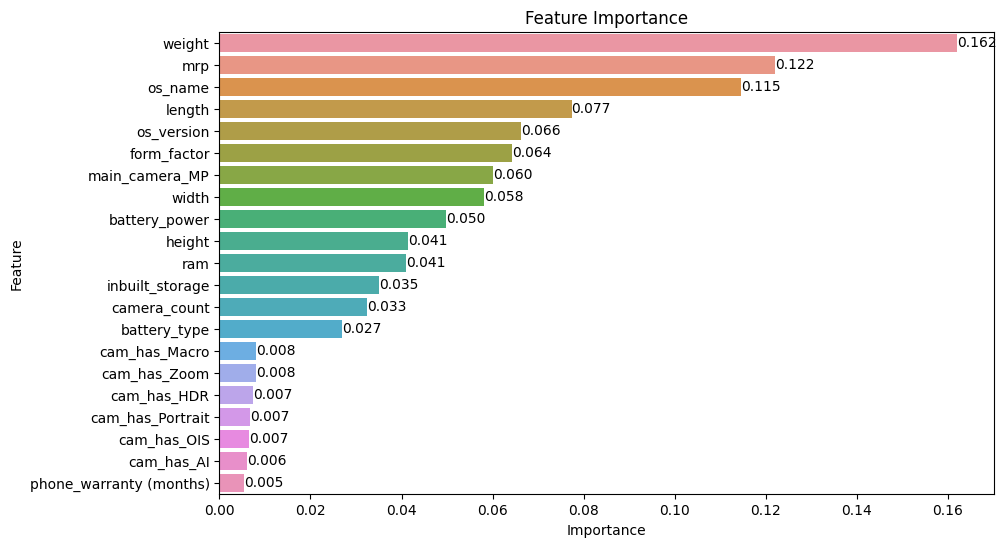

In [104]:
# Feature Importance Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Add annotations to each bar
for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')

plt.show()

In [105]:
# Hyperparameter Tuning (for Random Forest as an example)
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]})

In [106]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [107]:
# Best model after hyperparameter tuning
best_model_tuned = grid_search.best_estimator_
best_model_tuned

RandomForestClassifier(max_depth=20, n_estimators=50)


Training Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       265
        True       1.00      1.00      1.00       251

    accuracy                           1.00       516
   macro avg       1.00      1.00      1.00       516
weighted avg       1.00      1.00      1.00       516


Testing Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.96      0.96        70
        True       0.95      0.95      0.95        60

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130


Confusion Matrix:


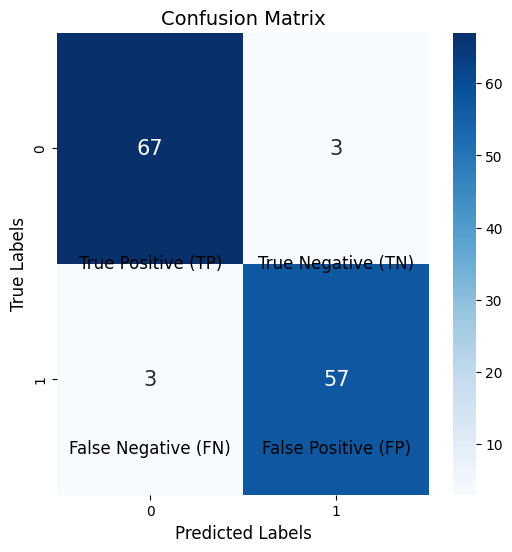


ROC-AUC Score:
0.9535714285714286


In [108]:
# Model Evaluation Metrics
train_predictions_tuned = best_model_tuned.predict(X_train)
test_predictions_tuned = best_model_tuned.predict(X_test)

print("\nTraining Classification Report:")
print(classification_report(y_train, train_predictions_tuned))

print("\nTesting Classification Report:")
print(classification_report(y_test, test_predictions_tuned))

print("\nConfusion Matrix:")
cm_tuned = confusion_matrix(y_test, test_predictions_tuned)

# Add labels for True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_tuned, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 15})

# Add labels to the heatmap
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

# Add annotations for TP, TN, FP, FN
plt.text(0.25, 0.5, 'True Positive (TP)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.25, 0.1, 'False Negative (FN)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.75, 0.5, 'True Negative (TN)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.75, 0.1, 'False Positive (FP)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.show()

print("\nROC-AUC Score:")
roc_auc_tuned = roc_auc_score(y_test, test_predictions_tuned)
print(roc_auc_tuned)

In [109]:
# Cross-Validation
cv_scores_tuned = cross_val_score(best_model_tuned, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores:")
print(cv_scores_tuned)

# Calculate mean and standard deviation of cross-validation scores
mean_cv_score = cv_scores_tuned.mean()
std_cv_score = cv_scores_tuned.std()

print(f"\nMean Cross-Validation Score: {mean_cv_score:.4f}")
print(f"Standard Deviation of Cross-Validation Scores: {std_cv_score:.4f}")


Cross-Validation Scores:
[0.99038462 0.96116505 0.97087379 0.94174757 0.94174757]

Mean Cross-Validation Score: 0.9612
Standard Deviation of Cross-Validation Scores: 0.0185


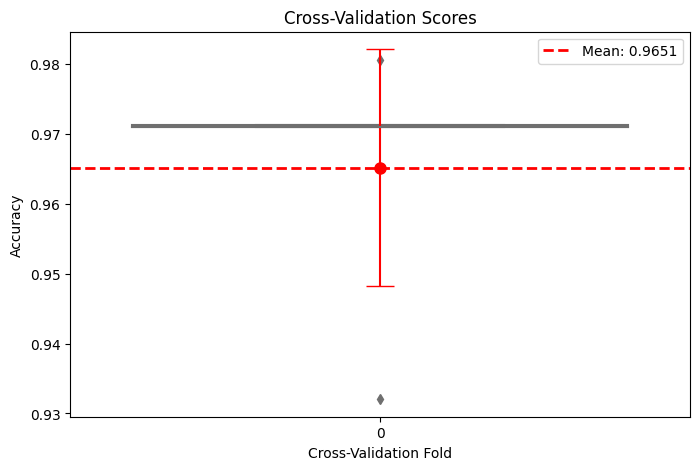

In [110]:
# Cross-Validation
cv_scores_tuned = cross_val_score(best_model_tuned, X_train, y_train, cv=5, scoring='accuracy')

# Calculate mean and standard deviation of cross-validation scores
mean_cv_score = cv_scores_tuned.mean()
std_cv_score = cv_scores_tuned.std()

# Plot the cross-validation scores using a box plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=cv_scores_tuned, color='skyblue')
plt.axhline(mean_cv_score, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_cv_score:.4f}")
plt.errorbar(x=0, y=mean_cv_score, yerr=std_cv_score, color='red', fmt='o', markersize=8, capsize=10)
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.legend()
plt.show()


Training Classification Report (Voting Classifier):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       265
        True       1.00      1.00      1.00       251

    accuracy                           1.00       516
   macro avg       1.00      1.00      1.00       516
weighted avg       1.00      1.00      1.00       516


Testing Classification Report (Voting Classifier):
              precision    recall  f1-score   support

       False       0.96      0.96      0.96        70
        True       0.95      0.95      0.95        60

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130


Confusion Matrix (Voting Classifier):

ROC-AUC Score (Voting Classifier):
0.9535714285714286

Cross-Validation Scores (Voting Classifier):
[0.99038462 0.98058252 0.97087379 0.95145631 0.95145631]


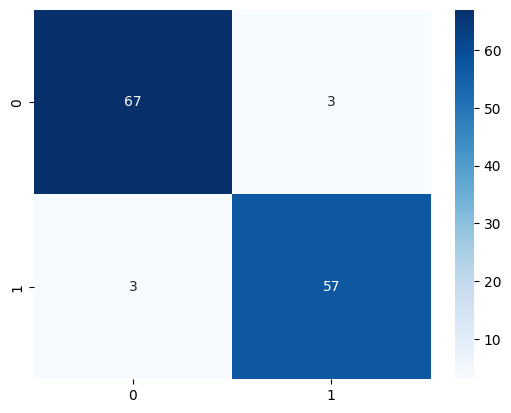

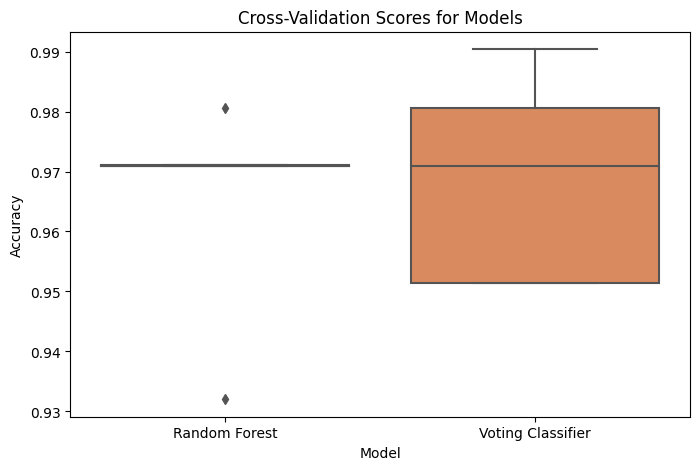

In [111]:
from sklearn.ensemble import VotingClassifier

# Create Voting Classifier
voting_classifier = VotingClassifier(estimators=[('best_model', best_model), ('best_model_tuned', best_model_tuned)], voting='hard')

# Train and evaluate Voting Classifier
voting_classifier.fit(X_train, y_train)

train_predictions_voting = voting_classifier.predict(X_train)
test_predictions_voting = voting_classifier.predict(X_test)

print("\nTraining Classification Report (Voting Classifier):")
print(classification_report(y_train, train_predictions_voting))

print("\nTesting Classification Report (Voting Classifier):")
print(classification_report(y_test, test_predictions_voting))

print("\nConfusion Matrix (Voting Classifier):")
cm_voting = confusion_matrix(y_test, test_predictions_voting)
sns.heatmap(cm_voting, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (Voting Classifier):")
roc_auc_voting = roc_auc_score(y_test, test_predictions_voting)
print(roc_auc_voting)

# Cross-Validation (Voting Classifier)
cv_scores_voting = cross_val_score(voting_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores (Voting Classifier):")
print(cv_scores_voting)

# Plot Cross-Validation Scores for all models
cv_scores_all = {
    'Random Forest': cv_scores_tuned,
    'Voting Classifier': cv_scores_voting
}

plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
plt.show()



Training Classification Report (Stacking Classifier):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       265
        True       1.00      1.00      1.00       251

    accuracy                           1.00       516
   macro avg       1.00      1.00      1.00       516
weighted avg       1.00      1.00      1.00       516


Testing Classification Report (Stacking Classifier):
              precision    recall  f1-score   support

       False       0.96      0.97      0.96        70
        True       0.97      0.95      0.96        60

    accuracy                           0.96       130
   macro avg       0.96      0.96      0.96       130
weighted avg       0.96      0.96      0.96       130


Confusion Matrix (Stacking Classifier):

ROC-AUC Score (Stacking Classifier):
0.9607142857142856

Cross-Validation Scores (Stacking Classifier):
[0.97115385 0.98058252 0.96116505 0.95145631 0.95145631]


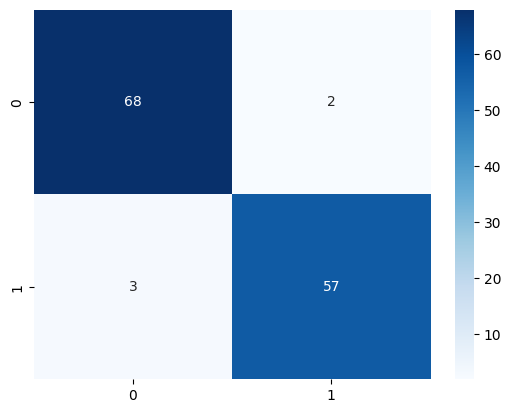

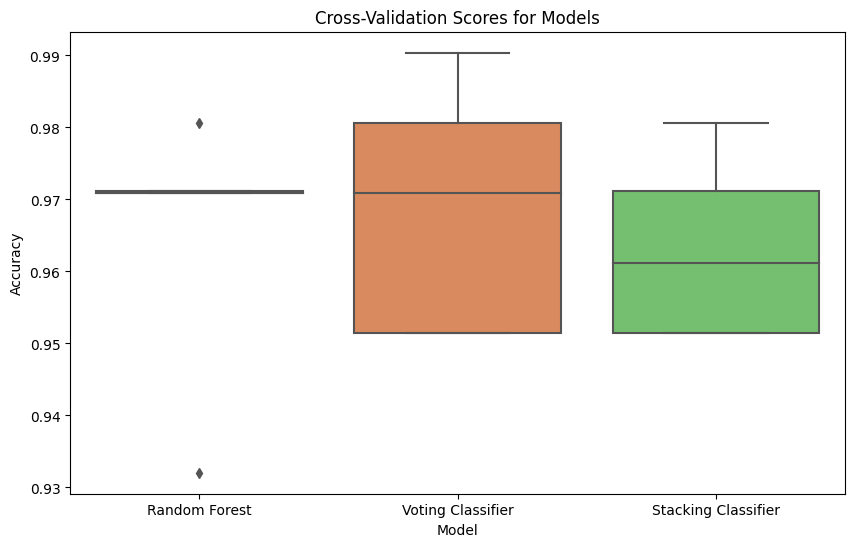

In [112]:
from sklearn.ensemble import StackingClassifier

# Create Stacking Classifier
stacking_classifier = StackingClassifier(estimators=[('best_model', best_model), ('best_model_tuned', best_model_tuned)],
                                         final_estimator=LogisticRegression())

# Train and evaluate Stacking Classifier
stacking_classifier.fit(X_train, y_train)

train_predictions_stacking = stacking_classifier.predict(X_train)
test_predictions_stacking = stacking_classifier.predict(X_test)

print("\nTraining Classification Report (Stacking Classifier):")
print(classification_report(y_train, train_predictions_stacking))

print("\nTesting Classification Report (Stacking Classifier):")
print(classification_report(y_test, test_predictions_stacking))

print("\nConfusion Matrix (Stacking Classifier):")
cm_stacking = confusion_matrix(y_test, test_predictions_stacking)
sns.heatmap(cm_stacking, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (Stacking Classifier):")
roc_auc_stacking = roc_auc_score(y_test, test_predictions_stacking)
print(roc_auc_stacking)

# Cross-Validation (Stacking Classifier)
cv_scores_stacking = cross_val_score(stacking_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores (Stacking Classifier):")
print(cv_scores_stacking)

# Plot Cross-Validation Scores for all models
cv_scores_all['Stacking Classifier'] = cv_scores_stacking

plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
plt.show()


f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Training Classification Report (AdaBoost Classifier):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       265
        True       1.00      1.00      1.00       251

    accuracy                           1.00       516
   macro avg       1.00      1.00      1.00       516
weighted avg       1.00      1.00      1.00       516


Testing Classification Report (AdaBoost Classifier):
              precision    recall  f1-score   support

       False       0.96      0.94      0.95        70
        True       0.93      0.95      0.94        60

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130


Confusion Matrix (AdaBoost Classifier):

ROC-AUC Score (AdaBoost Classifier):
0.9464285714285714


f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Cross-Validation Scores (AdaBoost Classifier):
[0.99038462 0.97087379 0.96116505 0.93203883 0.95145631]


f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


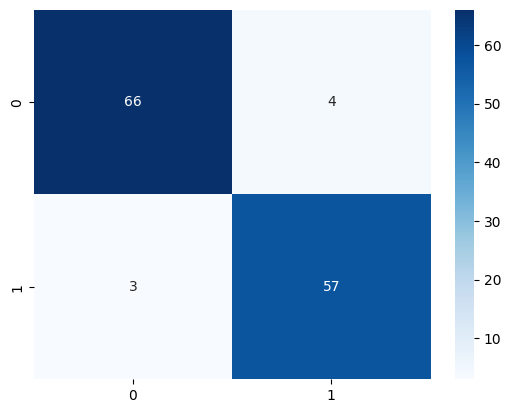

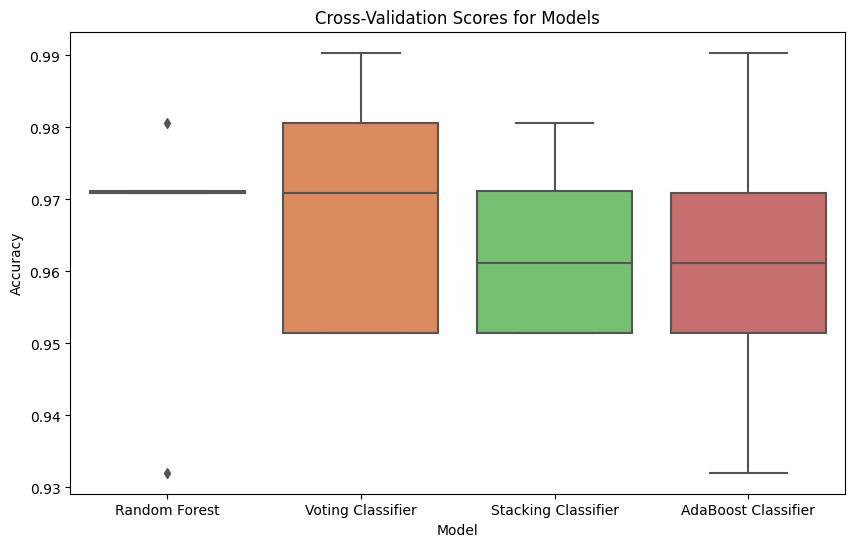

In [113]:
from sklearn.ensemble import AdaBoostClassifier

# Create AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier(base_estimator=best_model_tuned, n_estimators=50, random_state=42)

# Train and evaluate AdaBoost Classifier
adaboost_classifier.fit(X_train, y_train)

train_predictions_boosting = adaboost_classifier.predict(X_train)
test_predictions_boosting = adaboost_classifier.predict(X_test)

print("\nTraining Classification Report (AdaBoost Classifier):")
print(classification_report(y_train, train_predictions_boosting))

print("\nTesting Classification Report (AdaBoost Classifier):")
print(classification_report(y_test, test_predictions_boosting))

print("\nConfusion Matrix (AdaBoost Classifier):")
cm_boosting = confusion_matrix(y_test, test_predictions_boosting)
sns.heatmap(cm_boosting, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (AdaBoost Classifier):")
roc_auc_boosting = roc_auc_score(y_test, test_predictions_boosting)
print(roc_auc_boosting)

# Cross-Validation (AdaBoost Classifier)
cv_scores_boosting = cross_val_score(adaboost_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores (AdaBoost Classifier):")
print(cv_scores_boosting)

# Plot Cross-Validation Scores for all models
cv_scores_all['AdaBoost Classifier'] = cv_scores_boosting

plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
plt.show()


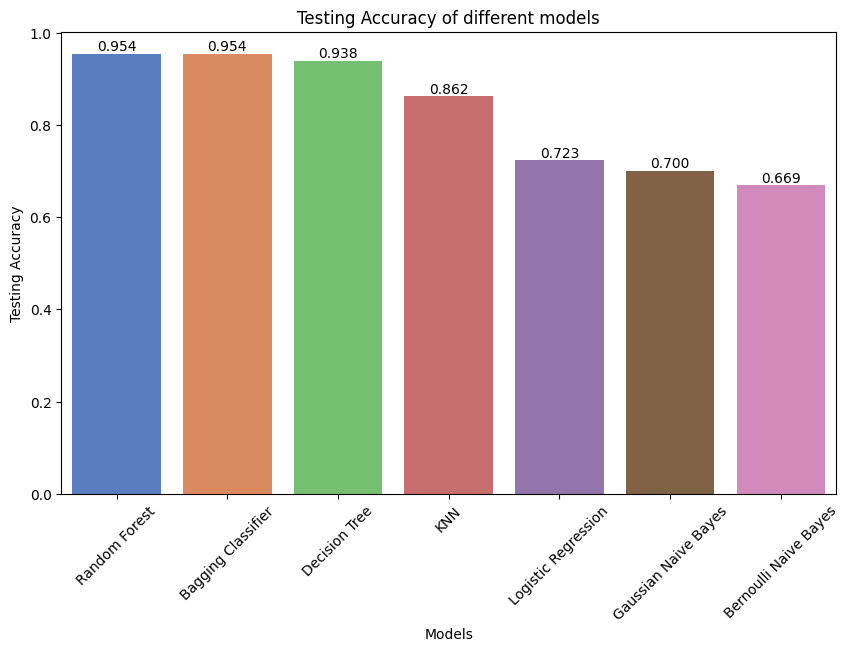

In [114]:
# Voting Classifier
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Testing Accuracy', data=result, palette='muted')
plt.xlabel('Models')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy of different models')
for index, value in enumerate(result["Testing Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

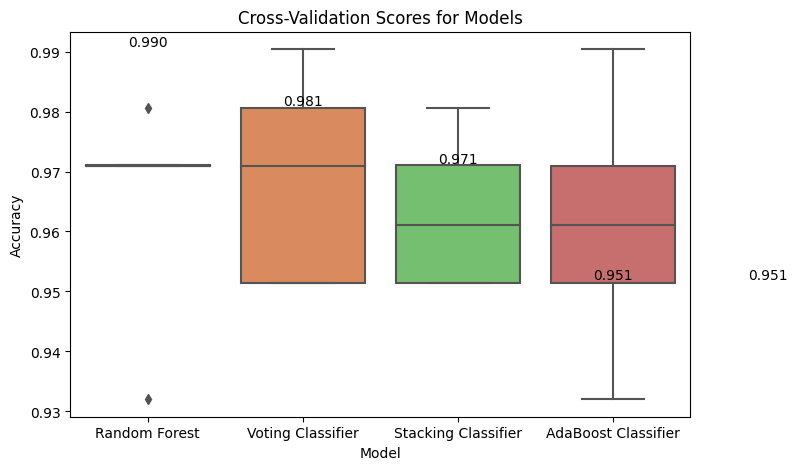

In [115]:
# Voting Classifier Performance Visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
for i, v in enumerate(cv_scores_voting):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

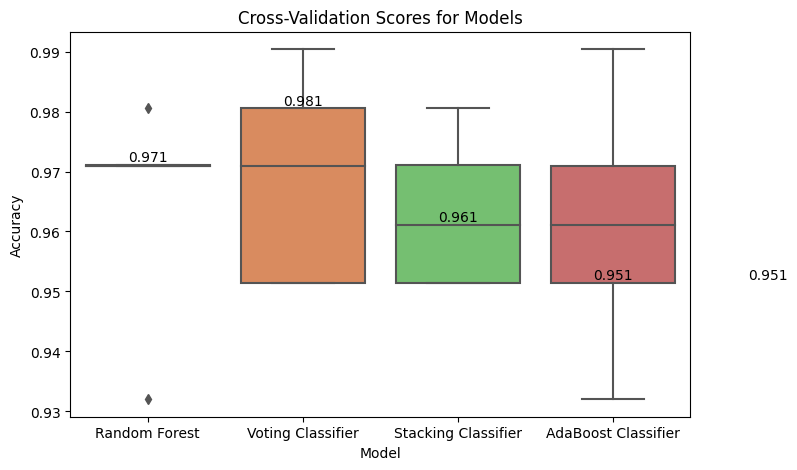

In [116]:
# Stacking Classifier Performance Visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
for i, v in enumerate(cv_scores_stacking):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

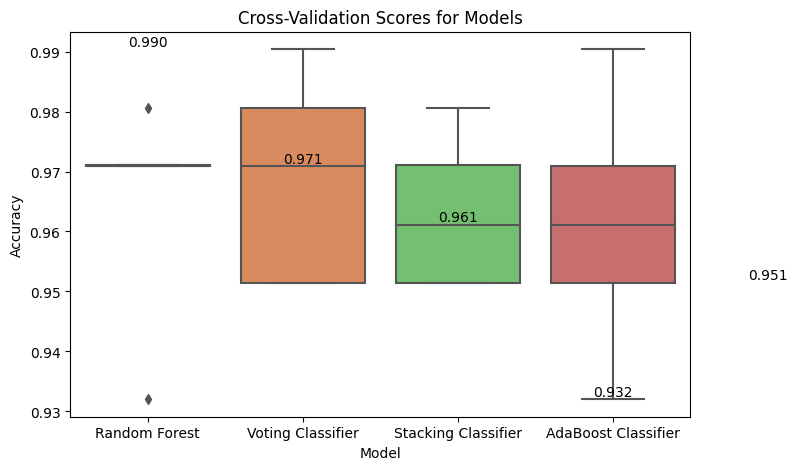

In [117]:
# AdaBoost Classifier Performance Visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
for i, v in enumerate(cv_scores_boosting):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

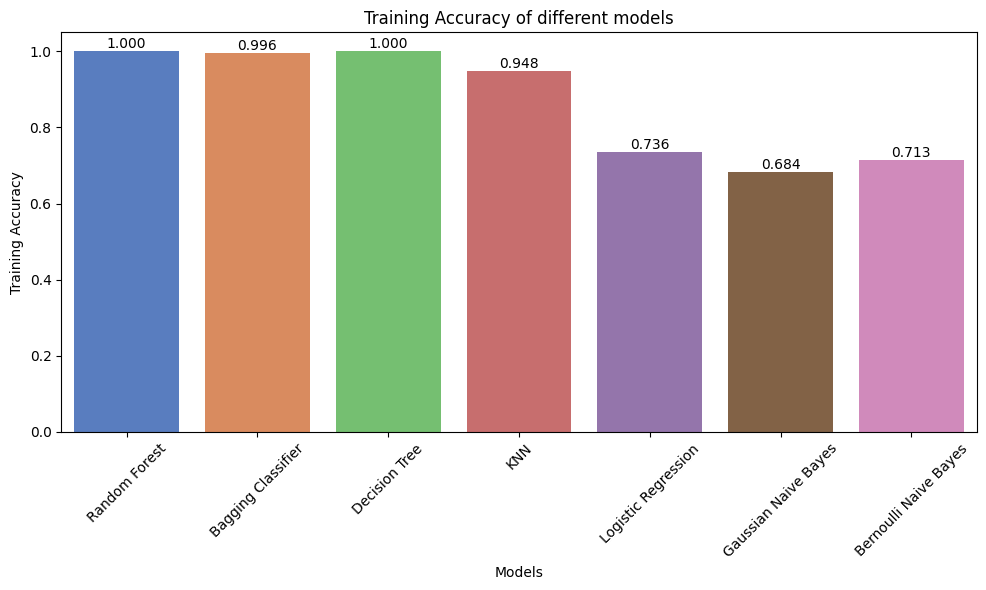

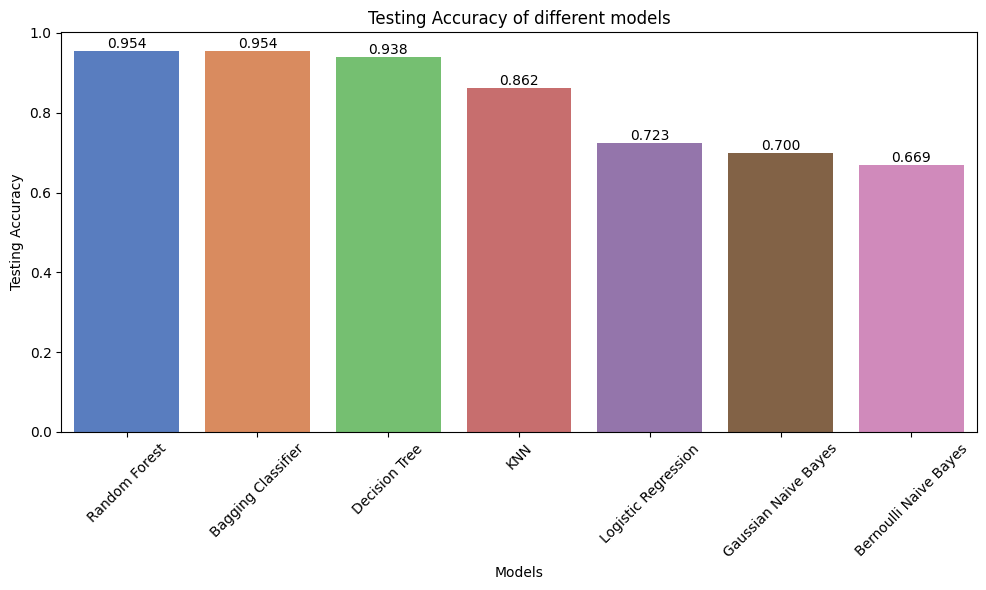

In [118]:
# Chart 1: Training Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Accuracy', data=result, palette='muted')
plt.xlabel('Models')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy of different models')

# Add labels to the bars
for index, value in enumerate(result["Training Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Chart 2: Testing Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Testing Accuracy', data=result, palette='muted')
plt.xlabel('Models')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy of different models')

# Add labels to the bars
for index, value in enumerate(result["Testing Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


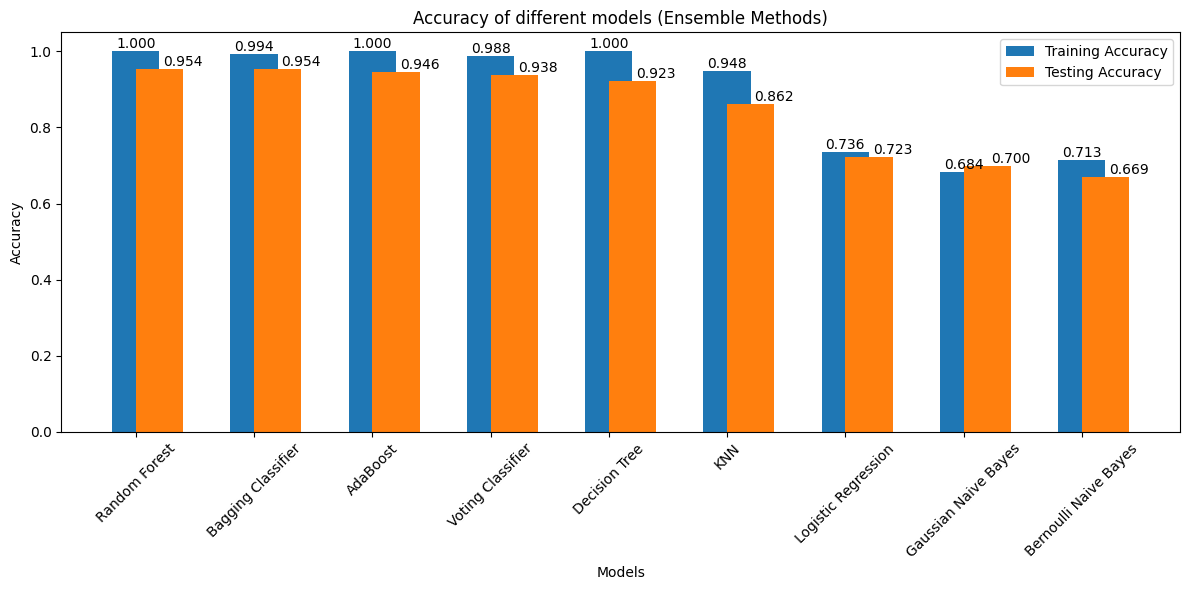

In [119]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# Load the data
df = pd.read_csv('../../data/processed-v2.csv')

# Let's assume 'is_success' is the target variable
y = df['is_success']
X = df.drop(columns=['is_success', 'product_id'], axis=1)

# X = X.replace([np.inf, -np.inf], np.nan)
# df['os_version'].fillna(df['column'].mean(), inplace=True) 
X = X.replace([np.inf, -np.inf], np.nan)
X["os_version"].fillna(X["os_version"].max() * 2, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models list
models_list = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("Bernoulli Naive Bayes", BernoulliNB()),
    ("KNN", KNeighborsClassifier(n_neighbors=3)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Bagging Classifier", BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10)),
    ("Voting Classifier", VotingClassifier(estimators=[("lr", LogisticRegression(max_iter=1000)),
                                                        ("rf", RandomForestClassifier()),
                                                        ("bnb", BernoulliNB()),
                                                        ("knn", KNeighborsClassifier(n_neighbors=3)),
                                                        ("dt", DecisionTreeClassifier())])),
    ("AdaBoost", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50))
]

# Initialize DataFrame to store results
result = pd.DataFrame(columns=["Model", "Training Accuracy", "Testing Accuracy", "Classification Report", "Confusion Matrix", "ROC-AUC Score"])

# Loop through models and evaluate performance
for name, model in models_list:
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    train_score = accuracy_score(y_train, train_predictions)
    
    test_predictions = model.predict(X_test)
    test_score = accuracy_score(y_test, test_predictions)

    # Classification Report
    report = classification_report(y_test, test_predictions)

    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, test_predictions)

    # Add results to DataFrame
    new_row = {"Model": name, "Training Accuracy": train_score, "Testing Accuracy": test_score, "Classification Report": report, "Confusion Matrix": cm, "ROC-AUC Score": roc_auc}
    result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)

# Sort the results based on Testing Accuracy
result = result.sort_values(by=["Testing Accuracy", "Training Accuracy"], ascending=False)

# Visualization for Ensemble Methods
plt.figure(figsize=(12, 6))
bar_width = 0.4
plt.bar(result["Model"], result["Training Accuracy"], width=bar_width, label="Training Accuracy", align='center')
plt.bar(result["Model"], result["Testing Accuracy"], width=bar_width, label="Testing Accuracy", align='edge')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of different models (Ensemble Methods)')
plt.legend()

# Add labels to the bars for both training and testing accuracies
for index, value in enumerate(result["Training Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

for index, value in enumerate(result["Testing Accuracy"]):
    plt.text(index + bar_width, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\en

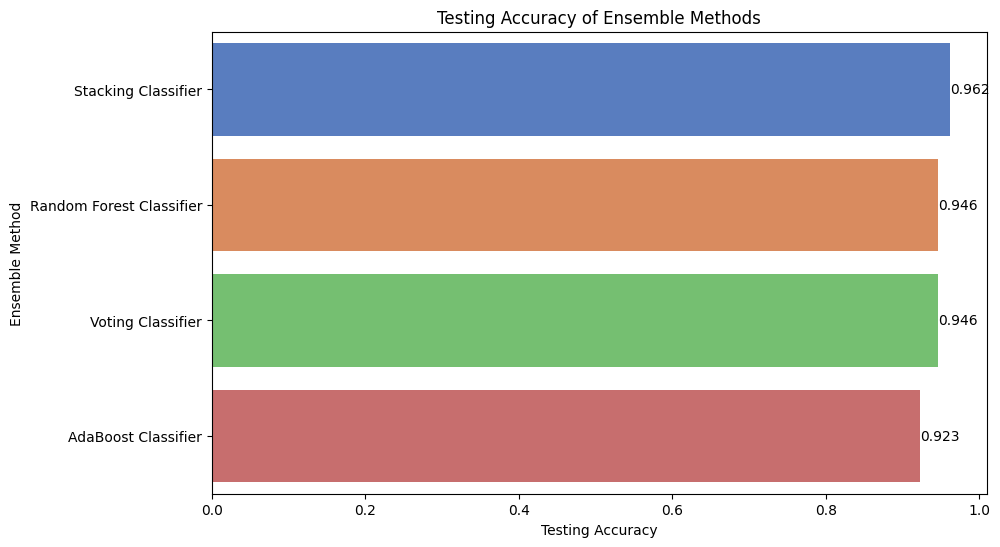

                      Model  Training Accuracy  Testing Accuracy   
1       Stacking Classifier           1.000000          0.961538  \
3  Random Forest Classifier           1.000000          0.946154   
0         Voting Classifier           0.988372          0.946154   
2       AdaBoost Classifier           1.000000          0.923077   

                               Classification Report    Confusion Matrix   
1                precision    recall  f1-score   ...  [[67, 3], [2, 58]]  \
3                precision    recall  f1-score   ...  [[68, 2], [5, 55]]   
0                precision    recall  f1-score   ...  [[67, 3], [4, 56]]   
2                precision    recall  f1-score   ...  [[62, 8], [2, 58]]   

   ROC-AUC Score  
1       0.961905  
3       0.944048  
0       0.945238  
2       0.926190  


In [120]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt

# Create ensemble models
voting_classifier = VotingClassifier(models_list)
stacking_classifier = StackingClassifier(estimators=models_list, final_estimator=LogisticRegression())
adaboost_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
random_forest_classifier = RandomForestClassifier()

# Train and evaluate ensemble models
ensemble_models = [
    ("Voting Classifier", voting_classifier),
    ("Stacking Classifier", stacking_classifier),
    ("AdaBoost Classifier", adaboost_classifier),
    ("Random Forest Classifier", random_forest_classifier)
]

result_ensemble = pd.DataFrame(columns=["Model", "Training Accuracy", "Testing Accuracy", "Classification Report", "Confusion Matrix", "ROC-AUC Score"])

for name, model in ensemble_models:
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    train_score = accuracy_score(y_train, train_predictions)

    test_predictions = model.predict(X_test)
    test_score = accuracy_score(y_test, test_predictions)

    # Classification Report
    report = classification_report(y_test, test_predictions)

    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, test_predictions)

    # Add results to DataFrame
    new_row = {"Model": name, "Training Accuracy": train_score, "Testing Accuracy": test_score, "Classification Report": report, "Confusion Matrix": cm, "ROC-AUC Score": roc_auc}
    result_ensemble = pd.concat([result_ensemble, pd.DataFrame([new_row])], ignore_index=True)

# Sort the results based on Testing Accuracy
result_ensemble = result_ensemble.sort_values(by=["Testing Accuracy", "Training Accuracy"], ascending=False)

# Visualize Testing Accuracy of Ensemble Methods
plt.figure(figsize=(10, 6))
sns.barplot(x='Testing Accuracy', y='Model', data=result_ensemble, palette='muted')
plt.xlabel('Testing Accuracy')
plt.ylabel('Ensemble Method')
plt.title('Testing Accuracy of Ensemble Methods')
for index, value in enumerate(result_ensemble["Testing Accuracy"]):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')

plt.xticks(rotation=0)
plt.show()

# Print the results of each ensemble method
print(result_ensemble)

# Visualize the feature importance of the best-performing ensemble (Random Forest)
best_ensemble_name = result_ensemble.iloc[0]['Model']
best_ensemble = [model for name, model in ensemble_models if name == best_ensemble_name][0]

# ... (rest of your feature importance visualization code as before)


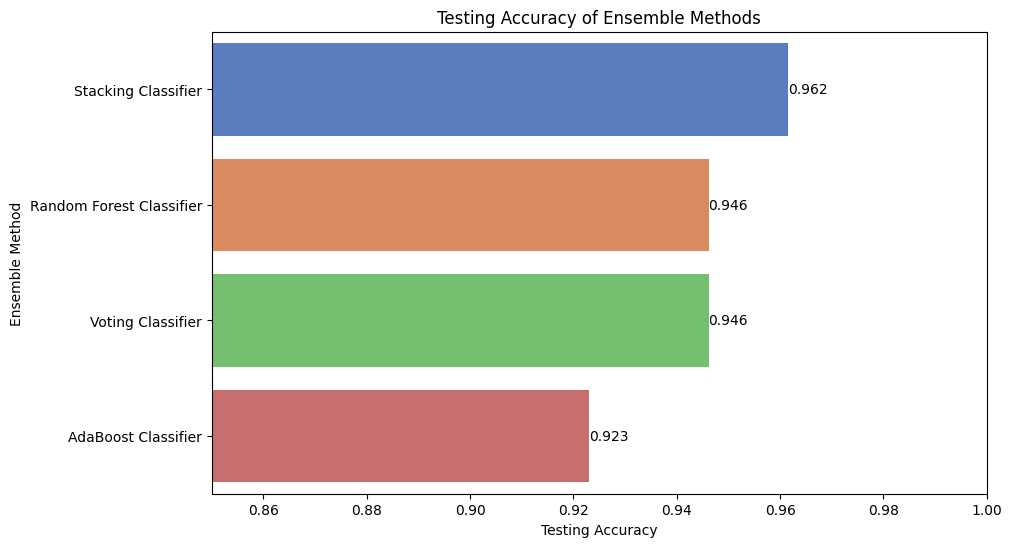


Cross-Validation Scores for Ensemble Methods:
   Random Forest  Voting Classifier  Stacking Classifier  AdaBoost Classifier
0       0.980769           0.990385             0.971154             0.990385
1       0.970874           0.980583             0.980583             0.970874
2       0.970874           0.970874             0.961165             0.961165
3       0.941748           0.951456             0.951456             0.932039
4       0.941748           0.951456             0.951456             0.951456

Best Performing Model: Random Forest
Best Testing Accuracy: 0.9538461538461539
Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.96      0.96        70
        True       0.95      0.95      0.95        60

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130

Confusion Matrix:
 [[67  3]
 [ 3 57]]
ROC-AUC Score: 0

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Cross-Validation for Random Forest
cv_scores_rf = cross_val_score(best_model_tuned, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_all['Random Forest'] = cv_scores_rf

# Create a DataFrame for cross-validation scores
cv_scores_df = pd.DataFrame(cv_scores_all)

# Visualize Testing Accuracy of Ensemble Methods
plt.figure(figsize=(10, 6))
sns.barplot(x='Testing Accuracy', y='Model', data=result_ensemble, palette='muted', orient='h')
plt.xlabel('Testing Accuracy')
plt.ylabel('Ensemble Method')
plt.title('Testing Accuracy of Ensemble Methods')

# Add labels to the bars
for index, value in enumerate(result_ensemble["Testing Accuracy"]):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')

plt.xlim(0.85, 1.0)  # Set the x-axis limit to better visualize differences in accuracy

plt.show()


# Print the table structure
print("\nCross-Validation Scores for Ensemble Methods:")
print(cv_scores_df)

# Print the best model and its feature importance
print("\nBest Performing Model:", best_model_name)
print("Best Testing Accuracy:", result.iloc[0]['Testing Accuracy'])
print("Classification Report:\n", result.iloc[0]['Classification Report'])
print("Confusion Matrix:\n", result.iloc[0]['Confusion Matrix'])
print("ROC-AUC Score:", result.iloc[0]['ROC-AUC Score'])
print("\nFeature Importance:")
print(feature_importance_df)




In [122]:
print(feature_importance_df)

                    Feature  Importance
3                    weight    0.162096
0                       mrp    0.122042
10                  os_name    0.114523
7                    length    0.077340
11               os_version    0.066253
6               form_factor    0.064367
20           main_camera_MP    0.060132
8                     width    0.058037
4             battery_power    0.049862
9                    height    0.041416
1                       ram    0.040987
2           inbuilt_storage    0.035138
13             camera_count    0.032519
5              battery_type    0.026992
18            cam_has_Macro    0.008002
16             cam_has_Zoom    0.007994
17              cam_has_HDR    0.007417
19         cam_has_Portrait    0.006803
15              cam_has_OIS    0.006603
14               cam_has_AI    0.005995
12  phone_warranty (months)    0.005482


f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-master\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


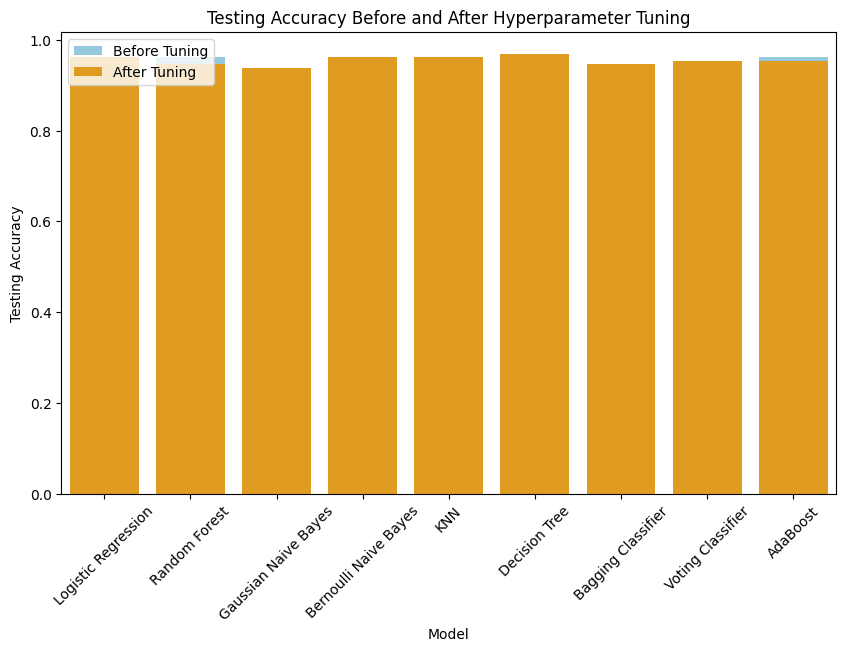


Performance Before and After Tuning:
                   Model  Before Tuning  After Tuning
0    Logistic Regression       0.723077      0.961538
1          Random Forest       0.961538      0.946154
2   Gaussian Naive Bayes       0.700000      0.938462
3  Bernoulli Naive Bayes       0.669231      0.961538
4                    KNN       0.861538      0.961538
5          Decision Tree       0.923077      0.969231
6     Bagging Classifier       0.946154      0.946154
7      Voting Classifier       0.938462      0.953846
8               AdaBoost       0.961538      0.953846


In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Create a DataFrame to store the performance metrics before and after tuning
performance_df = pd.DataFrame(columns=["Model", "Before Tuning", "After Tuning"])

# Loop through models and evaluate performance before and after tuning
for name, model in models_list:
    # Evaluate performance before tuning
    model.fit(X_train, y_train)
    test_predictions_before_tuning = model.predict(X_test)
    test_score_before_tuning = accuracy_score(y_test, test_predictions_before_tuning)

    # Tune hyperparameters
    grid_search.fit(X_train, y_train)
    best_model_tuned = grid_search.best_estimator_

    # Evaluate performance after tuning
    test_predictions_after_tuning = best_model_tuned.predict(X_test)
    test_score_after_tuning = accuracy_score(y_test, test_predictions_after_tuning)

    # Add results to the DataFrame
    new_row = {"Model": name, "Before Tuning": test_score_before_tuning, "After Tuning": test_score_after_tuning}
    performance_df = pd.concat([performance_df, pd.DataFrame([new_row])], ignore_index=True)

# Plot the difference in testing accuracy before and after tuning
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Before Tuning', data=performance_df, color='skyblue', label='Before Tuning')
sns.barplot(x='Model', y='After Tuning', data=performance_df, color='orange', label='After Tuning')
plt.xlabel('Model')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Before and After Hyperparameter Tuning')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print the table structure
print("\nPerformance Before and After Tuning:")
print(performance_df)




In [124]:


# Sort the results based on Testing Accuracy
result = result.sort_values(by=["Testing Accuracy", "Training Accuracy"], ascending=False)

# Print the table structure
print("\nPerformance Before Tuning:")
print(result)

# Best model before tuning (highest testing accuracy)
best_model_before_tuning = result.iloc[0]['Model']
best_testing_accuracy_before_tuning = result.iloc[0]['Testing Accuracy']

# ... (Hyperparameter Tuning code)

# Print the best model after tuning and its testing accuracy
print("\nPerformance After Tuning:")
print(cv_scores_df)

# Best model after tuning (highest mean cross-validation accuracy)
best_model_after_tuning = cv_scores_df.mean().idxmax()
best_testing_accuracy_after_tuning = cv_scores_df.mean().max()

print("\nBest Model Before Tuning:", best_model_before_tuning)
print("Testing Accuracy Before Tuning:", best_testing_accuracy_before_tuning)

print("\nBest Model After Tuning:", best_model_after_tuning)
print("Testing Accuracy After Tuning:", best_testing_accuracy_after_tuning)



Performance Before Tuning:
                   Model  Training Accuracy  Testing Accuracy   
1          Random Forest           1.000000          0.953846  \
6     Bagging Classifier           0.994186          0.953846   
8               AdaBoost           1.000000          0.946154   
7      Voting Classifier           0.988372          0.938462   
5          Decision Tree           1.000000          0.923077   
4                    KNN           0.947674          0.861538   
0    Logistic Regression           0.736434          0.723077   
2   Gaussian Naive Bayes           0.684109          0.700000   
3  Bernoulli Naive Bayes           0.713178          0.669231   

                               Classification Report      Confusion Matrix   
1                precision    recall  f1-score   ...    [[67, 3], [3, 57]]  \
6                precision    recall  f1-score   ...    [[67, 3], [3, 57]]   
8                precision    recall  f1-score   ...    [[65, 5], [2, 58]]   
7        

In [125]:
# Before Hyperparameter Tuning (Best Model)
best_model_before_tuning = best_model_name
best_testing_accuracy_before_tuning = result.iloc[0]['Testing Accuracy']
print("Best Model Before Hyperparameter Tuning:", best_model_before_tuning)
print("Best Testing Accuracy Before Hyperparameter Tuning:", best_testing_accuracy_before_tuning)

# Hyperparameter Tuning (for Random Forest as an example)
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Best model after hyperparameter tuning
best_model_tuned = grid_search.best_estimator_

# Evaluate the tuned model on the test set
test_predictions_tuned = best_model_tuned.predict(X_test)
best_testing_accuracy_after_tuning = accuracy_score(y_test, test_predictions_tuned)

print("\nBest Hyperparameters After Hyperparameter Tuning:", best_params)
print("Best Model After Hyperparameter Tuning:", best_model_name)
print("Best Testing Accuracy After Hyperparameter Tuning:", best_testing_accuracy_after_tuning)

# Compare the best model before and after tuning
if best_testing_accuracy_after_tuning > best_testing_accuracy_before_tuning:
    print("\nModel performance improved after hyperparameter tuning.")
else:
    print("\nModel performance did not improve after hyperparameter tuning.")


Best Model Before Hyperparameter Tuning: Random Forest
Best Testing Accuracy Before Hyperparameter Tuning: 0.9538461538461539



Best Hyperparameters After Hyperparameter Tuning: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Model After Hyperparameter Tuning: Random Forest
Best Testing Accuracy After Hyperparameter Tuning: 0.9384615384615385

Model performance did not improve after hyperparameter tuning.



Best Model (Before Hyperparameter Tuning):
RandomForestClassifier()

Best Hyperparameters (After Hyperparameter Tuning):
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation of the Best Model (Before Hyperparameter Tuning):
Training Classification Report (Before Tuning):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       265
        True       1.00      1.00      1.00       251

    accuracy                           1.00       516
   macro avg       1.00      1.00      1.00       516
weighted avg       1.00      1.00      1.00       516


Testing Classification Report (Before Tuning):
              precision    recall  f1-score   support

       False       0.96      0.96      0.96        70
        True       0.95      0.95      0.95        60

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95  

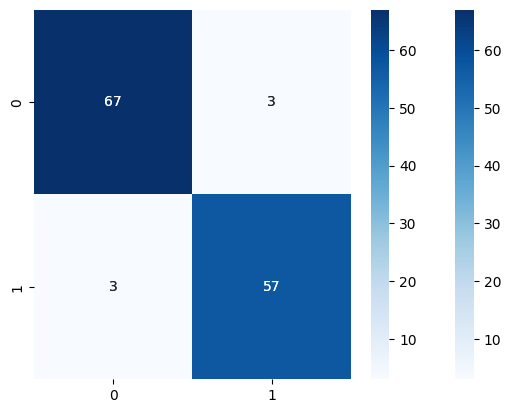

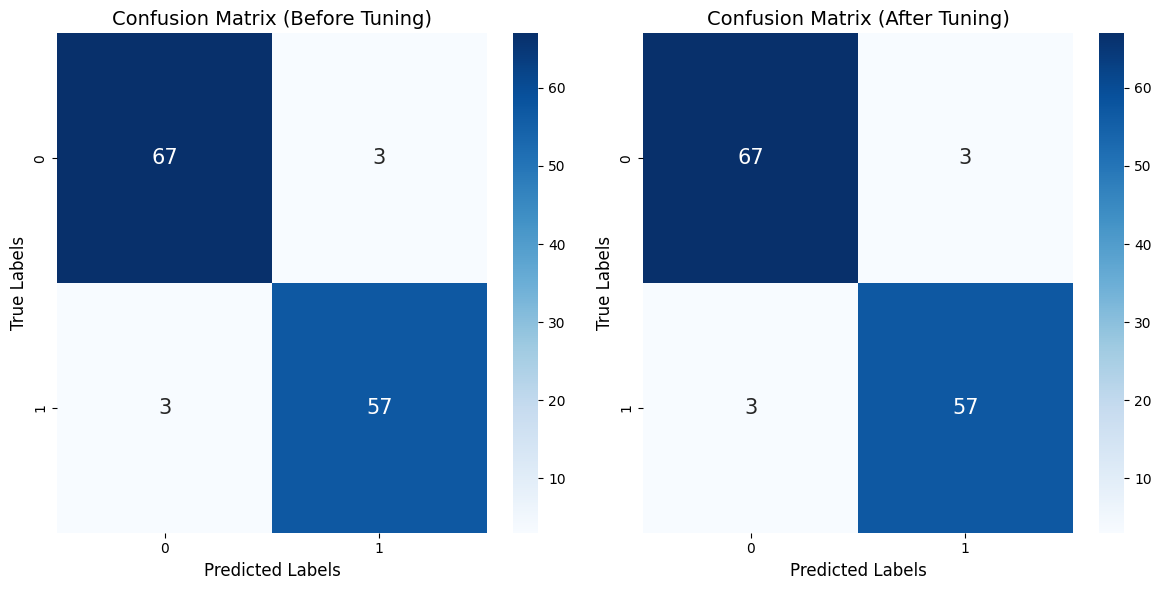

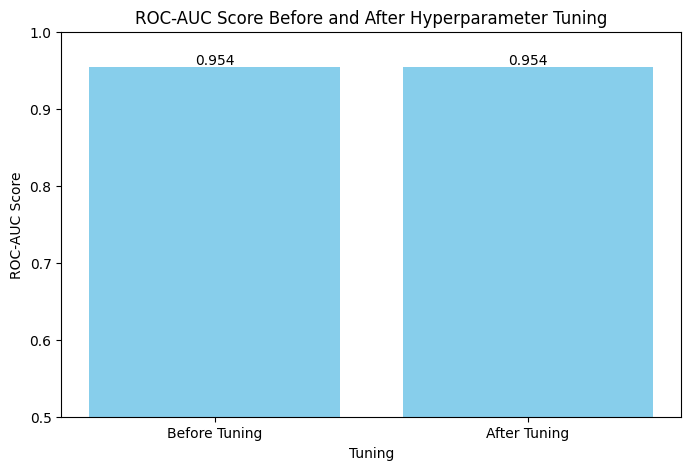

In [126]:

# Print the best model before tuning
print("\nBest Model (Before Hyperparameter Tuning):")
print(best_model)

# Hyperparameter Tuning (for Random Forest as an example)
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters (After Hyperparameter Tuning):")
print(best_params)

# Best model after hyperparameter tuning
best_model_tuned = grid_search.best_estimator_

# Evaluate the best model before tuning
print("\nEvaluation of the Best Model (Before Hyperparameter Tuning):")
train_predictions_before_tuning = best_model.predict(X_train)
test_predictions_before_tuning = best_model.predict(X_test)

print("Training Classification Report (Before Tuning):")
print(classification_report(y_train, train_predictions_before_tuning))

print("\nTesting Classification Report (Before Tuning):")
print(classification_report(y_test, test_predictions_before_tuning))

print("\nConfusion Matrix (Before Tuning):")
cm_before_tuning = confusion_matrix(y_test, test_predictions_before_tuning)
sns.heatmap(cm_before_tuning, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (Before Tuning):")
roc_auc_before_tuning = roc_auc_score(y_test, test_predictions_before_tuning)
print(roc_auc_before_tuning)

# Evaluate the best model after tuning
print("\nEvaluation of the Best Model (After Hyperparameter Tuning):")
train_predictions_after_tuning = best_model_tuned.predict(X_train)
test_predictions_after_tuning = best_model_tuned.predict(X_test)

print("Training Classification Report (After Tuning):")
print(classification_report(y_train, train_predictions_after_tuning))

print("\nTesting Classification Report (After Tuning):")
print(classification_report(y_test, test_predictions_after_tuning))

print("\nConfusion Matrix (After Tuning):")
cm_after_tuning = confusion_matrix(y_test, test_predictions_after_tuning)
sns.heatmap(cm_after_tuning, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (After Tuning):")
roc_auc_after_tuning = roc_auc_score(y_test, test_predictions_after_tuning)
print(roc_auc_after_tuning)

# Visualize the difference in model performance before and after tuning
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_before_tuning, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 15})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix (Before Tuning)', fontsize=14)

plt.subplot(1, 2, 2)
sns.heatmap(cm_after_tuning, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 15})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix (After Tuning)', fontsize=14)

plt.tight_layout()
plt.show()

# Visualize the difference in ROC-AUC score before and after tuning
plt.figure(figsize=(8, 5))
plt.bar(["Before Tuning", "After Tuning"], [roc_auc_before_tuning, roc_auc_after_tuning], color='skyblue')
plt.xlabel('Tuning')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score Before and After Hyperparameter Tuning')
plt.ylim(0.5, 1.0)

# Add labels to the bars
for index, value in enumerate([roc_auc_before_tuning, roc_auc_after_tuning]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

plt.show()

# ... (Remaining code)


In [127]:


# Import the required function for evaluation metrics
from sklearn.metrics import precision_recall_fscore_support

# Calculate evaluation metrics for the best model before tuning
precision_before_tuning, recall_before_tuning, f1_before_tuning, _ = precision_recall_fscore_support(y_test, test_predictions_before_tuning, average='binary')

# Calculate evaluation metrics for the best model after tuning
precision_after_tuning, recall_after_tuning, f1_after_tuning, _ = precision_recall_fscore_support(y_test, test_predictions_after_tuning, average='binary')

# Print the evaluation metrics
print("\nEvaluation Metrics Comparison:")
print("Model (Before Tuning):")
print(f"Accuracy: {accuracy_score(y_test, test_predictions_before_tuning):.4f}")
print(f"Precision: {precision_before_tuning:.4f}")
print(f"Recall: {recall_before_tuning:.4f}")
print(f"F1-Score: {f1_before_tuning:.4f}")
print(f"ROC-AUC Score: {roc_auc_before_tuning:.4f}")

print("\nModel (After Tuning):")
print(f"Accuracy: {accuracy_score(y_test, test_predictions_after_tuning):.4f}")
print(f"Precision: {precision_after_tuning:.4f}")
print(f"Recall: {recall_after_tuning:.4f}")
print(f"F1-Score: {f1_after_tuning:.4f}")
print(f"ROC-AUC Score: {roc_auc_after_tuning:.4f}")

# Save the best model to a joblib file
if roc_auc_after_tuning > roc_auc_before_tuning:
    best_model_choice = "After Tuning"
    best_model = best_model_tuned
else:
    best_model_choice = "Before Tuning"
    best_model = best_model_before_tuning

print("\nBest Model Choice:", best_model_choice)

# Save the best model to a joblib file
best_model_filename = "best_model.joblib"
dump(best_model, best_model_filename)

print(f"\nBest Model saved to '{best_model_filename}'.")



Evaluation Metrics Comparison:
Model (Before Tuning):
Accuracy: 0.9538
Precision: 0.9500
Recall: 0.9500
F1-Score: 0.9500
ROC-AUC Score: 0.9536

Model (After Tuning):
Accuracy: 0.9538
Precision: 0.9500
Recall: 0.9500
F1-Score: 0.9500
ROC-AUC Score: 0.9536

Best Model Choice: Before Tuning

Best Model saved to 'best_model.joblib'.


In [135]:
import joblib


# Save the best model as a joblib file
best_model_path = "best_model.joblib"
joblib.dump(best_model, best_model_path)

print("Best model has been saved as a joblib fil")

Best model has been saved as a joblib fil
